In [ ]:
#------------------------------------------------
# ESTE CODIGO FUE EL ELEGIDO PARA ENVIARSE A LA PRUEBA MLSP2025 PARA LA TASK1 DE SAMPLEO ALEATORIO AL 0.5% (PARA EL 0.02% MODIFICAR DICHO PORCENTAJE EN EL CODIGO)
# COMO CONSINDERACIONES, EL CODIGO OBTIENE COMO ENTRADA DE CANALES 3 (RGB); 1 MASK;1 SPARSE; 2 POSICIÓN X & Y, SE RECOMIENDA PROBAR CON LAS DISTANCIAS A CADA CANAL PARA INTENTAR PROFUNDIZAR EN EL APRENDIZAJE SEGÚN LAS DISTANCIAS Y PROPORCIONES DEL ENTORNO.
# TAMBÍEN SE PUEDEN MEJORAR LAS CAPAS DE EXTRACCIÓN DE DATOS EN LOS BLOQUES DE CONVOLUCIÓN DE CADA CAPA DE LA UNET Y EL BOTTLENECK, TAMBIEN SE RECOMIENDA INTENTAR PROFUNDIZAR EN LOS DATA AUGMENTANTIONS Y EN LA PARTE FINAL DE SR, PODRÍAN OBTNERSE MEJORES RESULTADOS.
# ESTE CODIGO ENTRENA Y SE EJECUTA BASTANTE RAPIDO, CERCA DE 1-2 MINUTOS POR EPOCA Y EN VALIDAR CERCA DE 0.80ms POR IMAGEN.
# SE RECOMIENDA TENER CUIDADO CON EL BATCH SIZE, PUEDE SATURAR LA RAM Y HACER QUE EL ENTRENAMIENTO SE REINICIE
# SE PUEDE MEJORAR EN LA PERDIDA EN LOS BORDES Y ZONAS GRANDES, TAMBÍEN SE PUEDE MEJORAR EN PROBAR DISTINTOS TIPOS DE CONVOLUCIÓN Y DE ATENCIÓN
# TENGA EL CUENTA QUE EL DATASET ESTÁ EN DRIVE
# EL MEJOR INDICADOR DE APRENDIZAJE Y ENTRENAMIENTO DE ESTE MODELO LO DA EL "MAE" SE PUEDE VER QUE ENTRE MÁS BAJO ESTE VALOR MÁS APROXIMADA ES LA ESTIMACIÓN
import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt

# Montar Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive2', force_remount=True)

# ----------------------------------------------
#  Parámetros y rutas
# ----------------------------------------------
dataset_root = "/content/drive2/MyDrive/ICASSP2025_Dataset"
with open(os.path.join(dataset_root, 'extremos.json'), 'r') as f:
    data = json.load(f)

ext_in   = {'min': tuple(data['rgb_min']), 'max': tuple(data['rgb_max'])}
ext_out  = {'min': data['pl_min'],      'max': data['pl_max']}
inputs_path  = os.path.join(dataset_root, "Inputs/Task_2_ICASSP")
outputs_path = os.path.join(dataset_root, "Outputs/Task_2_ICASSP")

# ----------------------------------------------
#  Funciones de preprocesado
# ----------------------------------------------
def pad_crop_to_512(img, pad_value=0):
    H, W = img.shape[:2]
    if H >= 512:
        y0 = (H - 512) // 2
        img = img[y0:y0+512, :]
    else:
        pt = (512 - H) // 2; pb = 512 - H - pt
        img = cv2.copyMakeBorder(img, pt, pb, 0, 0, cv2.BORDER_CONSTANT, value=pad_value)
    H, W = img.shape[:2]
    if W >= 512:
        x0 = (W - 512) // 2
        img = img[:, x0:x0+512]
    else:
        pl = (512 - W) // 2; pr = 512 - W - pl
        img = cv2.copyMakeBorder(img, 0, 0, pl, pr, cv2.BORDER_CONSTANT, value=pad_value)
    return img


def normalize_rgb(img, ext):
    img = img.astype(np.float32)
    (minR, minG, minB), (maxR, maxG, maxB) = ext['min'], ext['max']
    R = (img[...,0] - minR) / (maxR - minR)
    G = (img[...,1] - minG) / (maxG - minG)
    B = (img[...,2] - minB) / (maxB - minB)
    return np.clip(np.stack([R, G, B], axis=-1), 0, 1)


def normalize_gray(img, ext):
    img = img.astype(np.float32)
    return np.clip((img - ext['min']) / (ext['max'] - ext['min']), 0, 1)

# CoordConv channels
coords = np.linspace(-1, 1, 512)
grid_y, grid_x = np.meshgrid(coords, coords, indexing='ij')
coord_channels = np.stack([grid_x, grid_y], axis=-1)  # (512,512,2)

# ----------------------------------------------
#  Construcción del dataset con repeat integrado
# ----------------------------------------------
def process_image(input_path, output_path, ext_in, ext_out, rate=0.005):
    im = cv2.cvtColor(cv2.imread(input_path), cv2.COLOR_BGR2RGB)
    im = pad_crop_to_512(im)
    rgb = normalize_rgb(im, ext_in)

    pl = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)
    pl = pad_crop_to_512(pl, pad_value=ext_out['min'])
    y  = normalize_gray(pl, ext_out)

    H, W = y.shape; N = H*W; k = int(N * rate)
    flat = np.zeros(N, np.float32)
    flat[np.random.choice(N, k, replace=False)] = 1.0
    mask = flat.reshape(H, W)
    sparse = y * mask

    x = np.concatenate([rgb, sparse[...,None], mask[...,None], coord_channels], axis=-1)
    return x.astype(np.float32), y[...,None].astype(np.float32)


def generator(in_paths, out_paths, ext_in, ext_out, rate):
    for inp, outp in zip(in_paths, out_paths):
        yield process_image(inp, outp, ext_in, ext_out, rate)


def ensure_shapes(x, y):
    tf.ensure_shape(x, (512,512,7)); tf.ensure_shape(y, (512,512,1))
    return x, y


def make_optimized_ds(in_paths, out_paths, ext_in, ext_out, rate, bs, is_train=True):
    ds = tf.data.Dataset.from_generator(
        lambda: generator(in_paths, out_paths, ext_in, ext_out, rate),
        output_signature=(
            tf.TensorSpec((512,512,7), tf.float32),
            tf.TensorSpec((512,512,1), tf.float32)
        )
    )
    if is_train:
        ds = ds.repeat()  # dataset infinito para entrenamiento
        ds = ds.shuffle(min(1000, len(in_paths)), reshuffle_each_iteration=True)
    ds = ds.map(ensure_shapes, tf.data.AUTOTUNE)
    ds = ds.batch(bs, drop_remainder=is_train).prefetch(tf.data.AUTOTUNE)
    return ds

# listar archivos y dividir conjuntos
files = sorted(os.listdir(inputs_path))
train_f, val_f = train_test_split(files, test_size=0.2, random_state=42)
train_in  = [os.path.join(inputs_path, f) for f in train_f]
train_out = [os.path.join(outputs_path, f) for f in train_f]
val_in    = [os.path.join(inputs_path, f) for f in val_f]
val_out   = [os.path.join(outputs_path, f) for f in val_f]

BATCH_SIZE   = 4
train_ds     = make_optimized_ds(train_in, train_out, ext_in, ext_out, 0.005, BATCH_SIZE, is_train=True)
val_ds       = make_optimized_ds(val_in,   val_out,   ext_in, ext_out, 0.005, BATCH_SIZE, is_train=False)

# ----------------------------------------------
#  Bloques: conv, ASPP, SelfAttention
# ----------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

class SelfAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.q = layers.Conv2D(filters//8, 1, padding='same')
        self.k = layers.Conv2D(filters//8, 1, padding='same')
        self.v = layers.Conv2D(filters,     1, padding='same')
        self.gamma = self.add_weight(shape=(), initializer='zeros', trainable=True)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        f = tf.reshape(self.q(x), [B, -1, C//8])
        g = tf.reshape(self.k(x), [B, -1, C//8])
        h = tf.reshape(self.v(x), [B, -1, C])
        att = tf.nn.softmax(tf.matmul(f, g, transpose_b=True), axis=-1)
        o = tf.matmul(att, h)
        o = tf.reshape(o, [B, H, W, C])
        return self.gamma * o + x

def aspp_module(x, filters, rates=[1, 6, 12, 18]):
    convs = []
    convs.append(layers.Conv2D(filters, 1, padding='same', activation='relu')(x))
    for r in rates:
        convs.append(layers.Conv2D(filters, 3, padding='same', dilation_rate=r, activation='relu')(x))
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,x.shape[-1]))(pool)
    pool = layers.Conv2D(filters, 1, padding='same', activation='relu')(pool)
    pool = layers.UpSampling2D((x.shape[1], x.shape[2]), interpolation='bilinear')(pool)
    convs.append(pool)
    x = layers.Concatenate()(convs)
    return layers.Conv2D(filters, 1, padding='same', activation='relu')(x)

# ----------------------------------------------
#  Construcción del modelo completo
# ----------------------------------------------
filters = [16, 32, 64, 128, 256, 512, 1024]
inputs  = layers.Input((512, 512, 7))
# Encoder
skip_connections = []
x = inputs
for i in range(len(filters) - 1):
    x = conv_block(x, filters[i])
    skip_connections.append(x)
    x = layers.MaxPool2D()(x)
# Bottleneck
b = aspp_module(x, filters[-1])
b = SelfAttention(filters[-1])(b)
b = SelfAttention(filters[-1])(b)
# Decoder
x = b
for i in range(len(filters) - 2, -1, -1):
    x = layers.Conv2DTranspose(filters[i], 3, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip_connections[i]])
    x = conv_block(x, filters[i])
# Salidas
boost_out = layers.Conv2D(1, 1, activation='linear', name='boost_map')(x)
sr = layers.Conv2D(64, 3, padding='same', activation='relu')(boost_out)
sr = layers.Conv2D(32, 3, padding='same', activation='relu')(sr)
sr = layers.Conv2D(1, 3, padding='same', activation='linear', name='boost_map_sr')(sr)
model = Model(inputs, sr)

# ----------------------------------------------
#  Learning Rate con Cosine Decay & callbacks
# ----------------------------------------------
initial_lr = 1e-4
final_lr   = 5e-8
total_epochs = 50
schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=total_epochs * math.ceil(len(train_in)/BATCH_SIZE),
    alpha=final_lr/initial_lr
)
optimizer = optimizers.Adam(learning_rate=schedule)

class LRLogger(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            current_lr = lr(self.model.optimizer.iterations).numpy()
        else:
            current_lr = lr.numpy()
        print(f"\nLearning rate for epoch {epoch+1} is {current_lr:.8f}")

callbacks_list = [
    LRLogger(),
    callbacks.ModelCheckpoint(
        os.path.join(dataset_root, 'enhanced_unet_best.h5'),
        save_best_only=True,
        monitor='val_loss'
    ),
    callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    callbacks.TensorBoard(log_dir=os.path.join(dataset_root, 'logs')),
    callbacks.CSVLogger(os.path.join(dataset_root, 'training_log.csv'))
]

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

# ----------------------------------------------
#  Entrenamiento
# ----------------------------------------------
history = model.fit(
    train_ds,  # Usar train_ds en lugar de train_ds_inf
    epochs=total_epochs,
    steps_per_epoch=math.ceil(len(train_in)/BATCH_SIZE),
    validation_data=val_ds,
    callbacks=callbacks_list
)

# Guardar modelo final
model.save(os.path.join(dataset_root, 'enhanced_deep_boost_unet0.52.h5'))

Mounted at /content/drive2


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 512, 512,  │      1,024 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_109[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 512, 512,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_110[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 256, 256,  │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_111[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_112[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_113[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_14

 Total params: 49,328,244 (188.17 MB)

 Trainable params: 49,320,180 (188.14 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0211 - mae: 0.0869


Learning rate for epoch 1 is 0.00009990
750/750 ━━━━━━━━━━━━━━━━━━━━ 236s 195ms/step - loss: 0.0211 - mae: 0.0869 - val_loss: 0.0048 - val_mae: 0.0384
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0039 - mae: 0.0354


Learning rate for epoch 2 is 0.00009961
750/750 ━━━━━━━━━━━━━━━━━━━━ 154s 206ms/step - loss: 0.0039 - mae: 0.0354 - val_loss: 0.0023 - val_mae: 0.0255
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0022 - mae: 0.0253


Learning rate for epoch 3 is 0.00009911
750/750 ━━━━━━━━━━━━━━━━━━━━ 153s 204ms/step - loss: 0.0022 - mae: 0.0253 - val_loss: 0.0017 - val_mae: 0.0211
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0017 - mae: 0.0224


Learning rate for epoch 4 is 0.00009843
750/750 ━━━━━━━━━━━━━━━━━━━━ 150s 200ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0012 - val_mae: 0.0182
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0017 - mae: 0.0217


Learning rate for epoch 5 is 0.00009755
750/750 ━━━━━━━━━━━━━━━━━━━━ 148s 198ms/step - loss: 0.0017 - mae: 0.0217 - val_loss: 0.0010 - val_mae: 0.0168
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0015 - mae: 0.0204
Learning rate for epoch 6 is 0.00009649
750/750 ━━━━━━━━━━━━━━━━━━━━ 140s 186ms/step - loss: 0.0015 - mae: 0.0204 - val_loss: 0.0011 - val_mae: 0.0176
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 8.1005e-04 - mae: 0.0148


Learning rate for epoch 7 is 0.00009524
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 188ms/step - loss: 8.1010e-04 - mae: 0.0148 - val_loss: 6.5328e-04 - val_mae: 0.0128
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0011 - mae: 0.0167
Learning rate for epoch 8 is 0.00009382
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 181ms/step - loss: 0.0011 - mae: 0.0167 - val_loss: 7.2972e-04 - val_mae: 0.0136
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 7.3175e-04 - mae: 0.0137
Learning rate for epoch 9 is 0.00009222
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 7.3179e-04 - mae: 0.0137 - val_loss: 7.9229e-04 - val_mae: 0.0141
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 8.2743e-04 - mae: 0.0144
Learning rate for epoch 10 is 0.00009046
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 8.2755e-04 - mae: 0.0144 - val_loss: 0.0046 - val_mae: 0.0412
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 9.4845e-04 - mae: 0.0155


Learning rate for epoch 11 is 0.00008853
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 192ms/step - loss: 9.4815e-04 - mae: 0.0155 - val_loss: 6.5182e-04 - val_mae: 0.0128
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 6.4227e-04 - mae: 0.0131


Learning rate for epoch 12 is 0.00008646
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 6.4228e-04 - mae: 0.0131 - val_loss: 5.7502e-04 - val_mae: 0.0123
Epoch 13/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 5.3619e-04 - mae: 0.0115


Learning rate for epoch 13 is 0.00008424
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - loss: 5.3617e-04 - mae: 0.0115 - val_loss: 5.1020e-04 - val_mae: 0.0108
Epoch 14/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.8008e-04 - mae: 0.0106


Learning rate for epoch 14 is 0.00008188
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 190ms/step - loss: 4.8007e-04 - mae: 0.0106 - val_loss: 4.3793e-04 - val_mae: 0.0099
Epoch 15/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 7.3168e-04 - mae: 0.0140
Learning rate for epoch 15 is 0.00007940
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 182ms/step - loss: 7.3149e-04 - mae: 0.0140 - val_loss: 4.6313e-04 - val_mae: 0.0103
Epoch 16/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 5.0113e-04 - mae: 0.0110
Learning rate for epoch 16 is 0.00007680
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 181ms/step - loss: 5.0110e-04 - mae: 0.0110 - val_loss: 6.2405e-04 - val_mae: 0.0130
Epoch 17/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.4100e-04 - mae: 0.0102


Learning rate for epoch 17 is 0.00007410
750/750 ━━━━━━━━━━━━━━━━━━━━ 145s 194ms/step - loss: 4.4101e-04 - mae: 0.0102 - val_loss: 4.0836e-04 - val_mae: 0.0096
Epoch 18/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.7557e-04 - mae: 0.0107


Learning rate for epoch 18 is 0.00007130
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 4.7554e-04 - mae: 0.0107 - val_loss: 3.7483e-04 - val_mae: 0.0090
Epoch 19/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.9975e-04 - mae: 0.0096
Learning rate for epoch 19 is 0.00006842
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 181ms/step - loss: 3.9975e-04 - mae: 0.0096 - val_loss: 4.0506e-04 - val_mae: 0.0095
Epoch 20/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.4906e-04 - mae: 0.0089


Learning rate for epoch 20 is 0.00006547
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 3.4907e-04 - mae: 0.0089 - val_loss: 3.6975e-04 - val_mae: 0.0089
Epoch 21/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.4503e-04 - mae: 0.0088
Learning rate for epoch 21 is 0.00006245
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 181ms/step - loss: 3.4505e-04 - mae: 0.0088 - val_loss: 3.9291e-04 - val_mae: 0.0096
Epoch 22/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.0055e-04 - mae: 0.0097


Learning rate for epoch 22 is 0.00005939
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - loss: 4.0051e-04 - mae: 0.0097 - val_loss: 3.5942e-04 - val_mae: 0.0088
Epoch 23/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.9065e-04 - mae: 0.0097


Learning rate for epoch 23 is 0.00005629
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 3.9062e-04 - mae: 0.0097 - val_loss: 3.2830e-04 - val_mae: 0.0088
Epoch 24/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 3.1550e-04 - mae: 0.0084


Learning rate for epoch 24 is 0.00005316
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - loss: 3.1548e-04 - mae: 0.0084 - val_loss: 3.0475e-04 - val_mae: 0.0079
Epoch 25/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 4.5169e-04 - mae: 0.0102
Learning rate for epoch 25 is 0.00005002
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 181ms/step - loss: 4.5163e-04 - mae: 0.0102 - val_loss: 3.2754e-04 - val_mae: 0.0085
Epoch 26/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.8970e-04 - mae: 0.0079
Learning rate for epoch 26 is 0.00004689
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 2.8977e-04 - mae: 0.0079 - val_loss: 3.4224e-04 - val_mae: 0.0086
Epoch 27/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.0758e-04 - mae: 0.0083
Learning rate for epoch 27 is 0.00004376
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 3.0756e-04 - mae: 0.0083 - val_loss: 3.4441e-04 - val_mae: 0.0085
Epoch 28/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.7571e-04 - mae: 0.0077
Learnin


Learning rate for epoch 31 is 0.00003163
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - loss: 2.6596e-04 - mae: 0.0075 - val_loss: 2.9911e-04 - val_mae: 0.0079
Epoch 32/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.5533e-04 - mae: 0.0074


Learning rate for epoch 32 is 0.00002875
750/750 ━━━━━━━━━━━━━━━━━━━━ 141s 188ms/step - loss: 2.5532e-04 - mae: 0.0074 - val_loss: 2.7855e-04 - val_mae: 0.0076
Epoch 33/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.6980e-04 - mae: 0.0077
Learning rate for epoch 33 is 0.00002595
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 181ms/step - loss: 2.6979e-04 - mae: 0.0077 - val_loss: 2.8401e-04 - val_mae: 0.0075
Epoch 34/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.4720e-04 - mae: 0.0072
Learning rate for epoch 34 is 0.00002325
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 2.4722e-04 - mae: 0.0072 - val_loss: 2.9448e-04 - val_mae: 0.0081
Epoch 35/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.6983e-04 - mae: 0.0076
Learning rate for epoch 35 is 0.00002065
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 2.6983e-04 - mae: 0.0076 - val_loss: 2.9927e-04 - val_mae: 0.0079
Epoch 36/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.3364e-04 - mae: 0.0070
Learnin


Learning rate for epoch 39 is 0.00001152
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - loss: 2.2728e-04 - mae: 0.0068 - val_loss: 2.6425e-04 - val_mae: 0.0072
Epoch 40/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 2.3907e-04 - mae: 0.0070
Learning rate for epoch 40 is 0.00000959
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 181ms/step - loss: 2.3907e-04 - mae: 0.0070 - val_loss: 2.8885e-04 - val_mae: 0.0077
Epoch 41/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.1681e-04 - mae: 0.0066
Learning rate for epoch 41 is 0.00000783
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 2.1682e-04 - mae: 0.0066 - val_loss: 2.9365e-04 - val_mae: 0.0078
Epoch 42/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.1533e-04 - mae: 0.0065
Learning rate for epoch 42 is 0.00000623
750/750 ━━━━━━━━━━━━━━━━━━━━ 135s 180ms/step - loss: 2.1534e-04 - mae: 0.0065 - val_loss: 2.6683e-04 - val_mae: 0.0073
Epoch 43/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.2244e-04 - mae: 0.0067
Learnin

Mounted at /content/drive2
Modelo cargado correctamente.
B10_Ant1_f1_S0.png -> RMSE_unseen: 2.4554 dB, time: 2.325s
B10_Ant1_f1_S1.png -> RMSE_unseen: 2.2192 dB, time: 0.097s
B10_Ant1_f1_S10.png -> RMSE_unseen: 2.3078 dB, time: 0.088s
B10_Ant1_f1_S11.png -> RMSE_unseen: 1.9818 dB, time: 0.088s
B10_Ant1_f1_S12.png -> RMSE_unseen: 2.0575 dB, time: 0.086s
B10_Ant1_f1_S13.png -> RMSE_unseen: 2.2200 dB, time: 0.086s
B10_Ant1_f1_S14.png -> RMSE_unseen: 2.4656 dB, time: 0.088s
B10_Ant1_f1_S15.png -> RMSE_unseen: 2.3662 dB, time: 0.088s
B10_Ant1_f1_S16.png -> RMSE_unseen: 2.4164 dB, time: 0.087s
B10_Ant1_f1_S17.png -> RMSE_unseen: 2.4038 dB, time: 0.088s
B10_Ant1_f1_S18.png -> RMSE_unseen: 2.3156 dB, time: 0.085s
B10_Ant1_f1_S19.png -> RMSE_unseen: 1.9295 dB, time: 0.086s
B10_Ant1_f1_S2.png -> RMSE_unseen: 2.3997 dB, time: 0.090s
B10_Ant1_f1_S20.png -> RMSE_unseen: 2.2974 dB, time: 0.086s
B10_Ant1_f1_S21.png -> RMSE_unseen: 2.3960 dB, time: 0.086s
B10_Ant1_f1_S22.png -> RMSE_unseen: 2.7492 dB,

KeyboardInterrupt: 

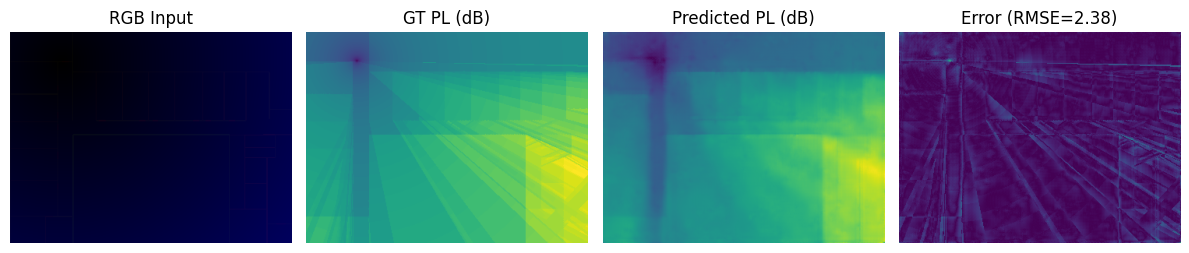

In [ ]:
# CODIGO DE CARGA Y VALIDACIÓN DEL MODELO

import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from google.colab import drive
import time

# ----------------------------------------------
# 1. Montar Google Drive y definir rutas
# ----------------------------------------------
drive.mount('/content/drive2', force_remount=True)
dataset_root = "/content/drive2/MyDrive/ICASSP2025_Dataset"
model_path   = os.path.join(dataset_root, 'enhanced_deep_boost_unet0.52.h5')
inputs_path  = os.path.join(dataset_root, "Inputs/Task_2_ICASSP")
outputs_path = os.path.join(dataset_root, "Outputs/Task_2_ICASSP")
ext_path     = os.path.join(dataset_root, 'extremos.json')
figs_dir     = os.path.join(dataset_root, 'figs_all')
os.makedirs(figs_dir, exist_ok=True)

# Cargar extremos
with open(ext_path, 'r') as f:
    data    = json.load(f)
    ext_in  = {'min': tuple(data['rgb_min']), 'max': tuple(data['rgb_max'])}
    ext_out = {'min': data['pl_min'],      'max': data['pl_max']}

# ----------------------------------------------
# 2. CoordConv grid (512×512)
# ----------------------------------------------
coords         = np.linspace(-1, 1, 512)
grid_y, grid_x = np.meshgrid(coords, coords, indexing='ij')
coord_channels = np.stack([grid_x, grid_y], axis=-1)

# ----------------------------------------------
# 3. Funciones de padding/unpadding
# ----------------------------------------------
def pad_crop_with_info(img, pad_val=0):
    H, W = img.shape[:2]
    # altura
    if H >= 512:
        pt = pb = 0
        img_p = img[(H-512)//2:(H-512)//2+512, :]
    else:
        pt = (512 - H)//2; pb = 512 - H - pt
        img_p = cv2.copyMakeBorder(img, pt, pb, 0, 0,
                                   cv2.BORDER_CONSTANT, value=pad_val)
    # anchura
    H2, W2 = img_p.shape[:2]
    if W2 >= 512:
        pl = pr = 0
        img_pc = img_p[:, (W2-512)//2:(W2-512)//2+512]
    else:
        pl = (512 - W2)//2; pr = 512 - W2 - pl
        img_pc = cv2.copyMakeBorder(img_p, 0, 0, pl, pr,
                                    cv2.BORDER_CONSTANT, value=pad_val)
    return img_pc, (pt, pb, pl, pr)

def unpad(img, pads):
    pt, pb, pl, pr = pads
    h, w = img.shape[:2]
    return img[pt:h-pb, pl:w-pr]

# ----------------------------------------------
# 4. Normalización / Desnormalización
# ----------------------------------------------
def normalize_rgb(img, ext):
    mi, ma = np.array(ext['min'], np.float32), np.array(ext['max'], np.float32)
    return np.clip((img.astype(np.float32) - mi) / (ma - mi), 0, 1)

def normalize_gray(img, ext):
    return np.clip((img.astype(np.float32) - ext['min']) / (ext['max'] - ext['min']), 0, 1)

def denormalize_gray(normed, ext):
    return normed * (ext['max'] - ext['min']) + ext['min']

# ----------------------------------------------
# 5. Preprocesado de una imagen
# ----------------------------------------------
def process_image(pi, pg, ext_in, ext_out, rate=0.005):
    im0 = cv2.cvtColor(cv2.imread(pi), cv2.COLOR_BGR2RGB)
    pl0 = cv2.imread(pg, cv2.IMREAD_GRAYSCALE)
    # pad/crop
    im, _    = pad_crop_with_info(im0, 0)
    pl, pads = pad_crop_with_info(pl0, ext_out['min'])
    # normalizar
    rgb    = normalize_rgb(im, ext_in)
    y_full = normalize_gray(pl, ext_out)
    # máscara esparcida
    H, W = y_full.shape; N = H*W; K = int(N * rate)
    flat = np.zeros(N, np.float32)
    flat[np.random.choice(N, K, replace=False)] = 1
    mask   = flat.reshape(H, W)
    sparse = y_full * mask
    # concatenar canales: [rgb(3), sparse(1), mask(1), coord(2)] = 7
    x = np.concatenate([rgb, sparse[...,None], mask[...,None], coord_channels],
                       axis=-1).astype(np.float32)
    return x, y_full[...,None].astype(np.float32), mask, pads

# ----------------------------------------------
# 6. Definición del modelo (idéntica a la del entrenamiento)
# ----------------------------------------------
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

class SelfAttention(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.q = layers.Conv2D(filters//8, 1, padding='same')
        self.k = layers.Conv2D(filters//8, 1, padding='same')
        self.v = layers.Conv2D(filters,     1, padding='same')
        self.gamma = self.add_weight(shape=(), initializer='zeros', trainable=True)
    def call(self, x):
        B, H, W, C = tf.shape(x)[0], x.shape[1], x.shape[2], x.shape[3]
        f = tf.reshape(self.q(x), [B, -1, C//8])
        g = tf.reshape(self.k(x), [B, -1, C//8])
        h = tf.reshape(self.v(x), [B, -1, C])
        att = tf.nn.softmax(tf.matmul(f, g, transpose_b=True), axis=-1)
        o = tf.matmul(att, h)
        o = tf.reshape(o, [B, H, W, C])
        return self.gamma * o + x

def aspp_module(x, filters, rates=[1,6,12,18]):
    convs = [layers.Conv2D(filters, 1, padding='same', activation='relu')(x)]
    for r in rates:
        convs.append(layers.Conv2D(filters, 3, padding='same',
                                   dilation_rate=r, activation='relu')(x))
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,x.shape[-1]))(pool)
    pool = layers.Conv2D(filters, 1, padding='same', activation='relu')(pool)
    pool = layers.UpSampling2D((x.shape[1],x.shape[2]), interpolation='bilinear')(pool)
    convs.append(pool)
    x = layers.Concatenate()(convs)
    return layers.Conv2D(filters, 1, padding='same', activation='relu')(x)

def build_model():
    filters = [16,32,64,128,256,512,1024]
    inp = layers.Input((512,512,7))
    skips = []
    x = inp
    # encoder
    for f in filters[:-1]:
        x = conv_block(x, f)
        skips.append(x)
        x = layers.MaxPool2D()(x)
    # bottleneck
    x = aspp_module(x, filters[-1])
    x = SelfAttention(filters[-1])(x)
    x = SelfAttention(filters[-1])(x)
    # decoder
    for i, f in enumerate(reversed(filters[:-1])):
        x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skips[-1-i]])
        x = conv_block(x, f)
    # heads
    boost = layers.Conv2D(1,1, name='boost_map')(x)
    sr    = layers.Conv2D(64,3, padding='same', activation='relu')(boost)
    sr    = layers.Conv2D(32,3, padding='same', activation='relu')(sr)
    out   = layers.Conv2D(1,3, padding='same', activation='linear',
                          name='boost_map_sr')(sr)
    return Model(inp, out)

# ----------------------------------------------
# 7. Cargar pesos y procesar todo el conjunto
# ----------------------------------------------
model = build_model()
model.load_weights(model_path)
print("Modelo cargado correctamente.")

files = sorted(os.listdir(inputs_path))
rmse_list = []
time_list = []

for fname in files:
    pi, pg = os.path.join(inputs_path, fname), os.path.join(outputs_path, fname)
    x, y_true_512, mask_512, pads = process_image(pi, pg, ext_in, ext_out)

    # inferencia
    t0 = time.time()
    y_pred_512 = model.predict(x[None], verbose=0)[0,...,0]
    t_inf = time.time() - t0

    # deshacer padding
    y_pr_crop = unpad(y_pred_512, pads)
    y_gt_crop = unpad(y_true_512[...,0], pads)
    mask_crop = unpad(mask_512, pads)

    # desnormalizar
    y_pr_db = denormalize_gray(y_pr_crop, ext_out)
    y_gt_db = denormalize_gray(y_gt_crop, ext_out)

    # RMSE en píxeles no muestreados
    unseen = (mask_crop == 0)
    rmse_u = np.sqrt(np.mean((y_pr_db[unseen] - y_gt_db[unseen])**2))

    rmse_list.append(rmse_u)
    time_list.append(t_inf)

    # guardar figura comparativa
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    for ax, img, title in zip(axs,
        [cv2.cvtColor(cv2.imread(pi), cv2.COLOR_BGR2RGB),
         y_gt_db, y_pr_db,
         np.abs(y_pr_db - y_gt_db)],
        ['RGB Input','GT PL (dB)','Predicted PL (dB)',f'Error (RMSE={rmse_u:.2f})']):
        ax.axis('off')
        if img.ndim == 2:
            ax.imshow(img, cmap='viridis')
        else:
            ax.imshow(img)
        ax.set_title(title)
    fig.tight_layout()
    fig.savefig(os.path.join(figs_dir, fname.replace('.png','.jpg')), dpi=150)
    plt.close(fig)

    print(f"{fname} -> RMSE_unseen: {rmse_u:.4f} dB, time: {t_inf:.3f}s")

# ----------------------------------------------
# 8. Resumen global
# ----------------------------------------------
print("\n===== GLOBAL SUMMARY =====")
print(f"Total images processed:       {len(rmse_list)}")
print(f"Mean RMSE_unseen (dB):        {np.mean(rmse_list):.4f}")
print(f"Std  RMSE_unseen (dB):        {np.std(rmse_list):.4f}")
print(f"Avg inference time (s):       {np.mean(time_list):.3f}")
